In [124]:
# Jupyter Notebook Approach for Stamford Zoning Analysis
# Cell 1: Import libraries and load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('Extract.csv.csv')

# Display basic info about the dataset
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
df.head()



Dataset shape: (38457, 16)
Columns: ['Property Address', 'Land sq. ft.', 'Zone', 'State Use Description', 'Gross Area of Primary Building', 'Living Area', 'Zone Description', 'Effective Area', 'Stories', 'Total Rooms', 'Number of Bedroom', 'Number of Bathrooms', 'Number of Half Bathrooms', 'Occupancy', 'Number of Units', 'Land Use Note']


,Property Address,Land sq. ft.,Zone,State Use Description,Gross Area of Primary Building,Living Area,Zone Description,Effective Area,Stories,Total Rooms,Number of Bedroom,Number of Bathrooms,Number of Half Bathrooms,Occupancy,Number of Units,Land Use Note
0,14 FIELDSTONE CIRCLE,11761,R10,Single Family,4948.0,2768.0,NaN,2976.0,2.0,8.0,4.0,2.0,1.0,1.0,NaN,NaN
1,18 FIELDSTONE CIRCLE,11083,R10,Single Family,6328.0,3761.0,NaN,3651.0,2.0,11.0,5.0,3.0,1.0,1.0,NaN,NaN
2,22 FIELDSTONE CIRCLE,10021,R10,Single Family,3618.0,2527.0,NaN,2527.0,2.0,8.0,4.0,2.0,1.0,1.0,NaN,NaN
3,28 FIELDSTONE CIRCLE,10052,R10,Single Family,3203.0,2376.0,NaN,2376.0,2.0,8.0,4.0,2.0,1.0,1.0,NaN,NaN
4,37 FIELDSTONE CIRCLE,13520,R10,Single Family,3528.0,2585.0,NaN,2595.0,2.5,6.0,3.0,2.0,1.0,1.0,NaN,NaN


In [125]:
print("Zone value counts:")
print(df['Zone'].value_counts())

print("\nUnique zones:")
print(sorted(df['Zone'].dropna().unique()))  # Add .dropna() here

# Check for missing values in key columns
print(f"\nMissing values in 'Land sq. ft.': {df['Land sq. ft.'].isna().sum()}")
print(f"Missing values in 'Zone': {df['Zone'].isna().sum()}")

Zone value counts:
Zone
R5      6288
RA1     5874
R75     4673
R10     4599
RMF     2711
R6      2345
RH      2056
R20     1913
RM1     1388
MZN     1071
RA2      707
CC       487
CWD      454
VC       418
RA3      406
MG       403
CL       389
RD       362
DWD      333
CN       310
CD       207
PD       149
ML       144
MXD      115
MRD      101
P         95
CB        68
TCDD      68
CG        58
NXD       48
CI        44
SRDS      31
RHD       21
SRDN      18
IPD       15
BD        11
HTD       10
CCN        5
MD         4
HCDD       4
CSCD       1
Name: count, dtype: int64

Unique zones:
['BD', 'CB', 'CC', 'CCN', 'CD', 'CG', 'CI', 'CL', 'CN', 'CSCD', 'CWD', 'DWD', 'HCDD', 'HTD', 'IPD', 'MD', 'MG', 'ML', 'MRD', 'MXD', 'MZN', 'NXD', 'P', 'PD', 'R10', 'R20', 'R5', 'R6', 'R75', 'RA1', 'RA2', 'RA3', 'RD', 'RH', 'RHD', 'RM1', 'RMF', 'SRDN', 'SRDS', 'TCDD', 'VC']

Missing values in 'Land sq. ft.': 0
Missing values in 'Zone': 53


In [126]:
# Add this as a new cell (Cell 2.5) after your data exploration

# Define residential zones we care about
residential_zones = ['RA3', 'RA2', 'RA1', 'R20', 'R10', 'R75', 'R6', 'R5', 'RM1', 'RMF', 'RH']

print(f"Original dataset size: {len(df):,} properties")

# Filter to only residential zones
df_residential = df[df['Zone'].isin(residential_zones)].copy()

print(f"Residential dataset size: {len(df_residential):,} properties")
print(f"Filtered out: {len(df) - len(df_residential):,} commercial/industrial properties")

# Show the residential zone distribution
print("\nResidential zone distribution:")
print(df_residential['Zone'].value_counts().sort_index())

# Continue with df_residential instead of df for the rest of your analysis
df = df_residential  # Replace the original dataframe

Original dataset size: 38,457 properties
Residential dataset size: 32,960 properties
Filtered out: 5,497 commercial/industrial properties

Residential zone distribution:
Zone
R10    4599
R20    1913
R5     6288
R6     2345
R75    4673
RA1    5874
RA2     707
RA3     406
RH     2056
RM1    1388
RMF    2711
Name: count, dtype: int64


In [127]:
# Cell 3: Define the zoning calculation function (CORRECTED)
def calculate_max_units(land_sq_ft, zone):
    """
    Calculate maximum number of units based on Stamford zoning regulations.
    
    Parameters:
    land_sq_ft (float): Land area in square feet
    zone (str): Zoning district code
    
    Returns:
    int: Maximum number of units allowed
    """
    
    # Handle missing or invalid data FIRST
    if pd.isna(land_sq_ft) or pd.isna(zone) or land_sq_ft <= 0:
        return 0
    
    # Clean zone name
    zone = str(zone).strip().upper()
    
    # Zoning regulations dictionary for simple zones
    zoning_rules = {
        'RA3': {'min_area': 130680, 'sf_per_unit': 130680, 'max_families': 1},
        'RA2': {'min_area': 87120, 'sf_per_unit': 87120, 'max_families': 1},
        'RA1': {'min_area': 43560, 'sf_per_unit': None, 'max_families': 1},
        'R20': {'min_area': 20000, 'sf_per_unit': 20000, 'max_families': 1},
        'R10': {'min_area': 10000, 'sf_per_unit': 10000, 'max_families': 1},
        'R75': {'min_area': 7500, 'sf_per_unit': 7500, 'max_families': 1},
        'RM1': {'min_area': 5000, 'sf_per_unit': 3750, 'max_families': None}
    }

    # R6 special tiers
    r6_tiers = [
        {'min_area': 5000, 'max_area': 6000, 'sf_per_unit': None, 'max_families': 1},
        {'min_area': 6000, 'max_area': float('inf'), 'sf_per_unit': None, 'max_families': 2}
    ]   
    
    # RMF special tiers
    rmf_tiers = [
        {'min_area': 5000, 'max_area': 20000, 'sf_per_unit': 2000, 'max_families': None},
        {'min_area': 20000, 'max_area': float('inf'), 'sf_per_unit': 1500, 'max_families': None}
    ]
    
    # RH special tiers
    rh_tiers = [
        {'min_area': 5000, 'max_area': 20000, 'sf_per_unit': 2000, 'max_families': None},
        {'min_area': 20000, 'max_area': 43560, 'sf_per_unit': 1250, 'max_families': None},
        {'min_area': 43560, 'max_area': float('inf'), 'sf_per_unit': 725, 'max_families': None}
    ]
    
    # R5 special tiers (CORRECTED - max_families as upper bound)
    r5_tiers = [
        {'min_area': 5000, 'max_area': 6000, 'sf_per_unit': None, 'max_families': 1},
        {'min_area': 6000, 'max_area': 9000, 'sf_per_unit': None, 'max_families': 2},
        {'min_area': 9000, 'max_area': 30000, 'sf_per_unit': 3000, 'max_families': 9},  
        {'min_area': 30000, 'max_area': float('inf'), 'sf_per_unit': 2500, 'max_families': None}
    ]
    
    # Special handling for tiered zones
    if zone == 'R6':
        for tier in r6_tiers:
            if tier['min_area'] <= land_sq_ft < tier['max_area']:
                if tier['sf_per_unit'] is not None:
                    calculated_units = max(1, int(land_sq_ft / tier['sf_per_unit']))
                    # Apply max_families cap if it exists
                    if tier['max_families'] is not None:
                        return min(calculated_units, tier['max_families'])
                    return calculated_units
                elif tier['max_families'] is not None:
                    return int(tier['max_families'])
                break
        return 1  # If lot is too small for minimum area

    elif zone == 'RMF':
        for tier in rmf_tiers:
            if tier['min_area'] <= land_sq_ft < tier['max_area']:
                if tier['sf_per_unit'] is not None:
                    calculated_units = max(1, int(land_sq_ft / tier['sf_per_unit']))
                    # Apply max_families cap if it exists
                    if tier['max_families'] is not None:
                        return min(calculated_units, tier['max_families'])
                    return calculated_units
                elif tier['max_families'] is not None:
                    return int(tier['max_families'])
                break
        return 1
        
    elif zone == 'RH':
        for tier in rh_tiers:
            if tier['min_area'] <= land_sq_ft < tier['max_area']:
                if tier['sf_per_unit'] is not None:
                    calculated_units = max(1, int(land_sq_ft / tier['sf_per_unit']))
                    # Apply max_families cap if it exists
                    if tier['max_families'] is not None:
                        return min(calculated_units, tier['max_families'])
                    return calculated_units
                elif tier['max_families'] is not None:
                    return int(tier['max_families'])
                break
        return 1  # If lot is too small for minimum area

    elif zone == 'R5':
        for tier in r5_tiers:
            if tier['min_area'] <= land_sq_ft < tier['max_area']:
                if tier['sf_per_unit'] is not None:
                    calculated_units = max(1, int(land_sq_ft / tier['sf_per_unit']))
                    # Apply max_families cap if it exists
                    if tier['max_families'] is not None:
                        return min(calculated_units, tier['max_families'])
                    return calculated_units
                elif tier['max_families'] is not None:
                    return int(tier['max_families'])
                break
        return 1  
        
    # Handle simple zones
    elif zone in zoning_rules:
        rules = zoning_rules[zone]
        
        # Check minimum area requirement
        if land_sq_ft < rules['min_area']:
            return 1
        
        # Calculate based on sf_per_unit if available
        if rules['max_families'] is not None:
            return int(rules['max_families'])
        
        elif rules['sf_per_unit'] is not None:
            return max(1, int(land_sq_ft / rules['sf_per_unit']))
        
    
    # Unknown zone
    return 0



In [128]:
# Cell 4: Test the function (move comprehensive testing here)
if __name__ == "__main__":
    test_cases = [
        # R-6 tests
        (5500, 'R6'),   # Should be 1 (5000-6000 range)
        (7000, 'R6'),   # Should be 2 (6000+ range)
        
        # RM-F tests
        (10000, 'RMF'), # Should be 5 (10000/2000)
        (25000, 'RMF'), # Should be 16 (25000/1500, 20000+ range)
        
        # R-H tests
        (10000, 'RH'),  # Should be 5 (10000/2000)
        (30000, 'RH'),  # Should be 24 (30000/1250, 20000-43560 range)
        (50000, 'RH'),  # Should be 68 (50000/725, 43560+ range)
        
        # R-5 tests (testing the upper bound logic)
        (5500, 'R5'),   # Should be 1 (5000-6000 range)
        (7000, 'R5'),   # Should be 2 (6000-9000 range)
        (15000, 'R5'),  # Should be 5 (15000/3000, 9000-30000 range)
        (27000, 'R5'),  # Should be 9 (27000/3000=9, capped at max_families=9)
        (30000, 'R5'),  # Should be 12 (30000/2500=12, but no longer capped at max_families)
        (40000, 'R5'),  # Should be 16 (40000/2500, 30000+ range, no cap)
        
        # Simple zone tests
        (50000, 'RA1'), # Should be 1 (50000/43560 = 1.14, rounded down)
        (100000, 'RA1'), # Should be 2
        
        # Edge cases
        (4000, 'R6'),   # Should be 0 (too small)
        (0, 'R5'),      # Should be 0 (invalid)
        (10000, 'UNKNOWN'), # Should be 0 (unknown zone)
    ]
    
    print("Testing the corrected function:")
    for land_area, zone in test_cases:
        max_units = calculate_max_units(land_area, zone)
        print(f"Land: {land_area:,} sq ft, Zone: {zone:>6} → Max Units: {max_units}")

Testing the corrected function:
Land: 5,500 sq ft, Zone:     R6 → Max Units: 1
Land: 7,000 sq ft, Zone:     R6 → Max Units: 2
Land: 10,000 sq ft, Zone:    RMF → Max Units: 5
Land: 25,000 sq ft, Zone:    RMF → Max Units: 16
Land: 10,000 sq ft, Zone:     RH → Max Units: 5
Land: 30,000 sq ft, Zone:     RH → Max Units: 24
Land: 50,000 sq ft, Zone:     RH → Max Units: 68
Land: 5,500 sq ft, Zone:     R5 → Max Units: 1
Land: 7,000 sq ft, Zone:     R5 → Max Units: 2
Land: 15,000 sq ft, Zone:     R5 → Max Units: 5
Land: 27,000 sq ft, Zone:     R5 → Max Units: 9
Land: 30,000 sq ft, Zone:     R5 → Max Units: 12
Land: 40,000 sq ft, Zone:     R5 → Max Units: 16
Land: 50,000 sq ft, Zone:    RA1 → Max Units: 1
Land: 100,000 sq ft, Zone:    RA1 → Max Units: 1
Land: 4,000 sq ft, Zone:     R6 → Max Units: 1
Land: 0 sq ft, Zone:     R5 → Max Units: 0
Land: 10,000 sq ft, Zone: UNKNOWN → Max Units: 0


In [129]:
# Cell 5: Apply the function to the entire dataframe
# Create the new column
print("Calculating max units for all properties...")
df_residential['Max Units'] = df.apply(
    lambda row: calculate_max_units(row['Land sq. ft.'], row['Zone']), 
    axis=1
)

print("Done! Here's a sample of the results:")
df_residential[['Property Address', 'Land sq. ft.', 'Zone', 'Max Units']].head(10)



Calculating max units for all properties...
Done! Here's a sample of the results:


,Property Address,Land sq. ft.,Zone,Max Units
0,14 FIELDSTONE CIRCLE,11761,R10,1
1,18 FIELDSTONE CIRCLE,11083,R10,1
2,22 FIELDSTONE CIRCLE,10021,R10,1
3,28 FIELDSTONE CIRCLE,10052,R10,1
4,37 FIELDSTONE CIRCLE,13520,R10,1
5,128 FIELDSTONE ROAD,12561,R10,1
6,122 FIELDSTONE ROAD,11448,R10,1
7,114 FIELDSTONE ROAD,10075,R10,1
8,98 FIELDSTONE ROAD,10032,R10,1
9,90 FIELDSTONE ROAD,11301,R10,1


In [130]:
# Cell 6: Analyze the results
# Summary statistics
print("Max Units Summary:")
print(df_residential['Max Units'].describe())

print(f"\nProperties with 0 max units: {(df_residential['Max Units'] == 0).sum()}")
print(f"Properties with 1+ max units: {(df_residential['Max Units'] > 0).sum()}")

# Group by zone to see patterns
zone_summary = df_residential.groupby('Zone').agg({
    'Max Units': ['count', 'mean', 'median', 'max'],
    'Land sq. ft.': 'mean'
}).round(2)

print("\nSummary by Zone:")
print(zone_summary)





Max Units Summary:
count    32960.000000
mean         1.077518
std          5.589579
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max        395.000000
Name: Max Units, dtype: float64

Properties with 0 max units: 9786
Properties with 1+ max units: 23174

Summary by Zone:
     Max Units                   Land sq. ft.
         count  mean median  max         mean
Zone                                         
R10       4599  1.00    1.0    1     14861.42
R20       1913  1.00    1.0    1     29082.69
R5        6288  0.82    0.0  169      2666.55
R6        2345  1.31    1.0    2      5697.04
R75       4673  0.98    1.0    1      9766.63
RA1       5874  1.00    1.0    1     58968.32
RA2        707  1.00    1.0    1    164804.64
RA3        406  1.00    1.0    1    305218.11
RH        2056  1.89    0.0  395      1520.58
RM1       1388  1.06    0.0  210      4251.59
RMF       2711  1.43    0.0  174      2973.80


In [131]:
# Zone Verification Cell - Check examples from each residential zone

# Get examples from each zone (if they exist in your data)
residential_zones = ['RA3', 'RA2', 'RA1', 'R20', 'R10', 'R75', 'R6', 'R5', 'RM1', 'RMF', 'RH']

print("=== ZONE VERIFICATION EXAMPLES ===\n")

for zone in residential_zones:
    zone_data = df_residential[df_residential['Zone'] == zone]
    
    if len(zone_data) > 0:
        print(f"📍 ZONE: {zone}")
        print(f"   Total properties: {len(zone_data)}")
        
        # Show 3-5 examples with different lot sizes
        examples = zone_data.nlargest(5, 'Land sq. ft.')[['Property Address', 'Land sq. ft.', 'Max Units']].head(3)
        examples = pd.concat([
            examples, 
            zone_data.nsmallest(3, 'Land sq. ft.')[['Property Address', 'Land sq. ft.', 'Max Units']].head(2)
        ]).drop_duplicates()
        
        for _, row in examples.iterrows():
            land_area = int(row['Land sq. ft.'])
            max_units = int(row['Max Units'])
            address = row['Property Address']
            
            # Manual calculation to verify
            manual_calc = calculate_max_units(land_area, zone)
            status = "✅" if manual_calc == max_units else "❌"
            
            print(f"   {status} {address}: {land_area:,} sq ft → {max_units} units")
            
            if manual_calc != max_units:
                print(f"      ⚠️  Expected: {manual_calc}, Got: {max_units}")
        
        # Show range of max units for this zone
        max_units_range = zone_data['Max Units'].value_counts().sort_index()
        print(f"   Max Units distribution: {dict(max_units_range)}")
        print()
        
    else:
        print(f"📍 ZONE: {zone} - No properties found in dataset")
        print()

# Summary statistics
print("=== OVERALL SUMMARY ===")
summary_by_zone = df_residential.groupby('Zone').agg({
    'Max Units': ['count', 'min', 'max', 'mean'],
    'Land sq. ft.': ['min', 'max', 'mean']
}).round(2)

print(summary_by_zone)

# Check for any anomalies
print("\n=== POTENTIAL ISSUES ===")

# Properties with unusually high max units
high_density = df_residential[df_residential['Max Units'] >= 20]
if len(high_density) > 0:
    print(f"⚠️  {len(high_density)} properties with 20+ max units:")
    print(high_density[['Property Address', 'Zone', 'Land sq. ft.', 'Max Units']].head())
else:
    print("✅ No properties with unusually high max units (20+)")

# Properties with 0 max units (shouldn't happen with residential zones)
zero_units = df_residential[df_residential['Max Units'] == 0]
if len(zero_units) > 0:
    print(f"\n❌ {len(zero_units)} residential properties with 0 max units (this shouldn't happen):")
    print(zero_units[['Property Address', 'Zone', 'Land sq. ft.', 'Max Units']].head())
    print("Zones with 0 max units:", zero_units['Zone'].value_counts().to_dict())
else:
    print("✅ No residential properties with 0 max units")

# Check for missing data
missing_land = df_residential['Land sq. ft.'].isna().sum()
missing_zone = df_residential['Zone'].isna().sum()
if missing_land > 0 or missing_zone > 0:
    print(f"\n⚠️  Missing data: {missing_land} properties missing land area, {missing_zone} missing zone")
else:
    print("✅ No missing land area or zone data")

=== ZONE VERIFICATION EXAMPLES ===

📍 ZONE: RA3
   Total properties: 406
   ✅ 0 FARMS ROAD: 8,788,230 sq ft → 1 units
   ✅ TRINITY PASS: 6,059,632 sq ft → 1 units
   ✅ 0 EAST MIDDLE PATENT ROAD: 5,622,725 sq ft → 1 units
   ✅ 355 TACONIC ROAD: 436 sq ft → 1 units
   ✅ 0 GUINEA ROAD: 436 sq ft → 1 units
   Max Units distribution: {1: 406}

📍 ZONE: RA2
   Total properties: 707
   ✅ 0 ERSKINE ROAD: 5,763,424 sq ft → 1 units
   ✅ 0 ROCK RIMMON ROAD : 4,159,544 sq ft → 1 units
   ✅ 39 SCOFIELDTOWN ROAD : 3,675,157 sq ft → 1 units
   ✅ 438 OLD LONG RIDGE ROAD: 0 sq ft → 0 units
   ✅ 0 RIVERBANK ROAD: 871 sq ft → 1 units
   Max Units distribution: {0: 1, 1: 706}

📍 ZONE: RA1
   Total properties: 5874
   ✅ 0 WEBBS HILL ROAD: 2,887,157 sq ft → 1 units
   ✅ 1708 NEWFIELD AVENUE: 1,883,534 sq ft → 1 units
   ✅ 0 HOPE STREET: 1,825,164 sq ft → 1 units
   ✅ 0 CUMMINGS POINT ROAD: 0 sq ft → 0 units
   ✅ 1620 NEWFIELD AVENUE: 0 sq ft → 0 units
   Max Units distribution: {0: 18, 1: 5856}

📍 ZONE: R20


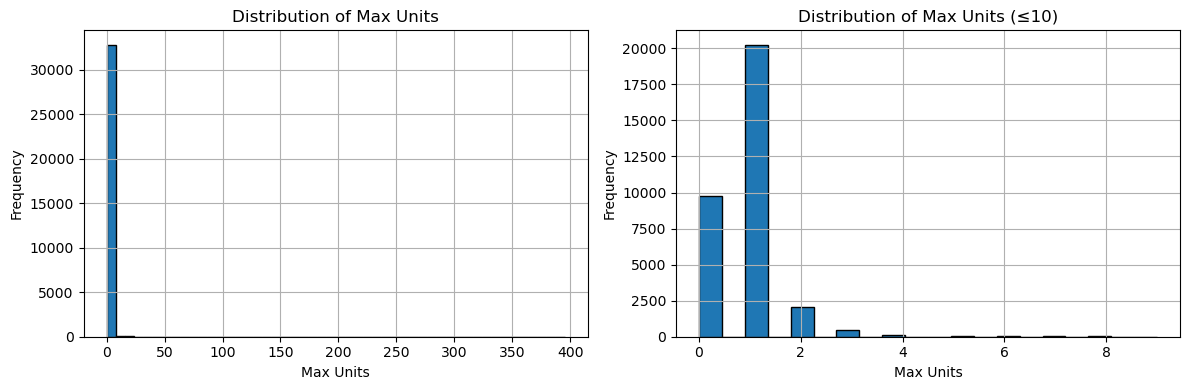

C:\Users\1isad\AppData\Local\Temp\ipykernel_19936\1777091671.py:29: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1400x600 with 0 Axes>

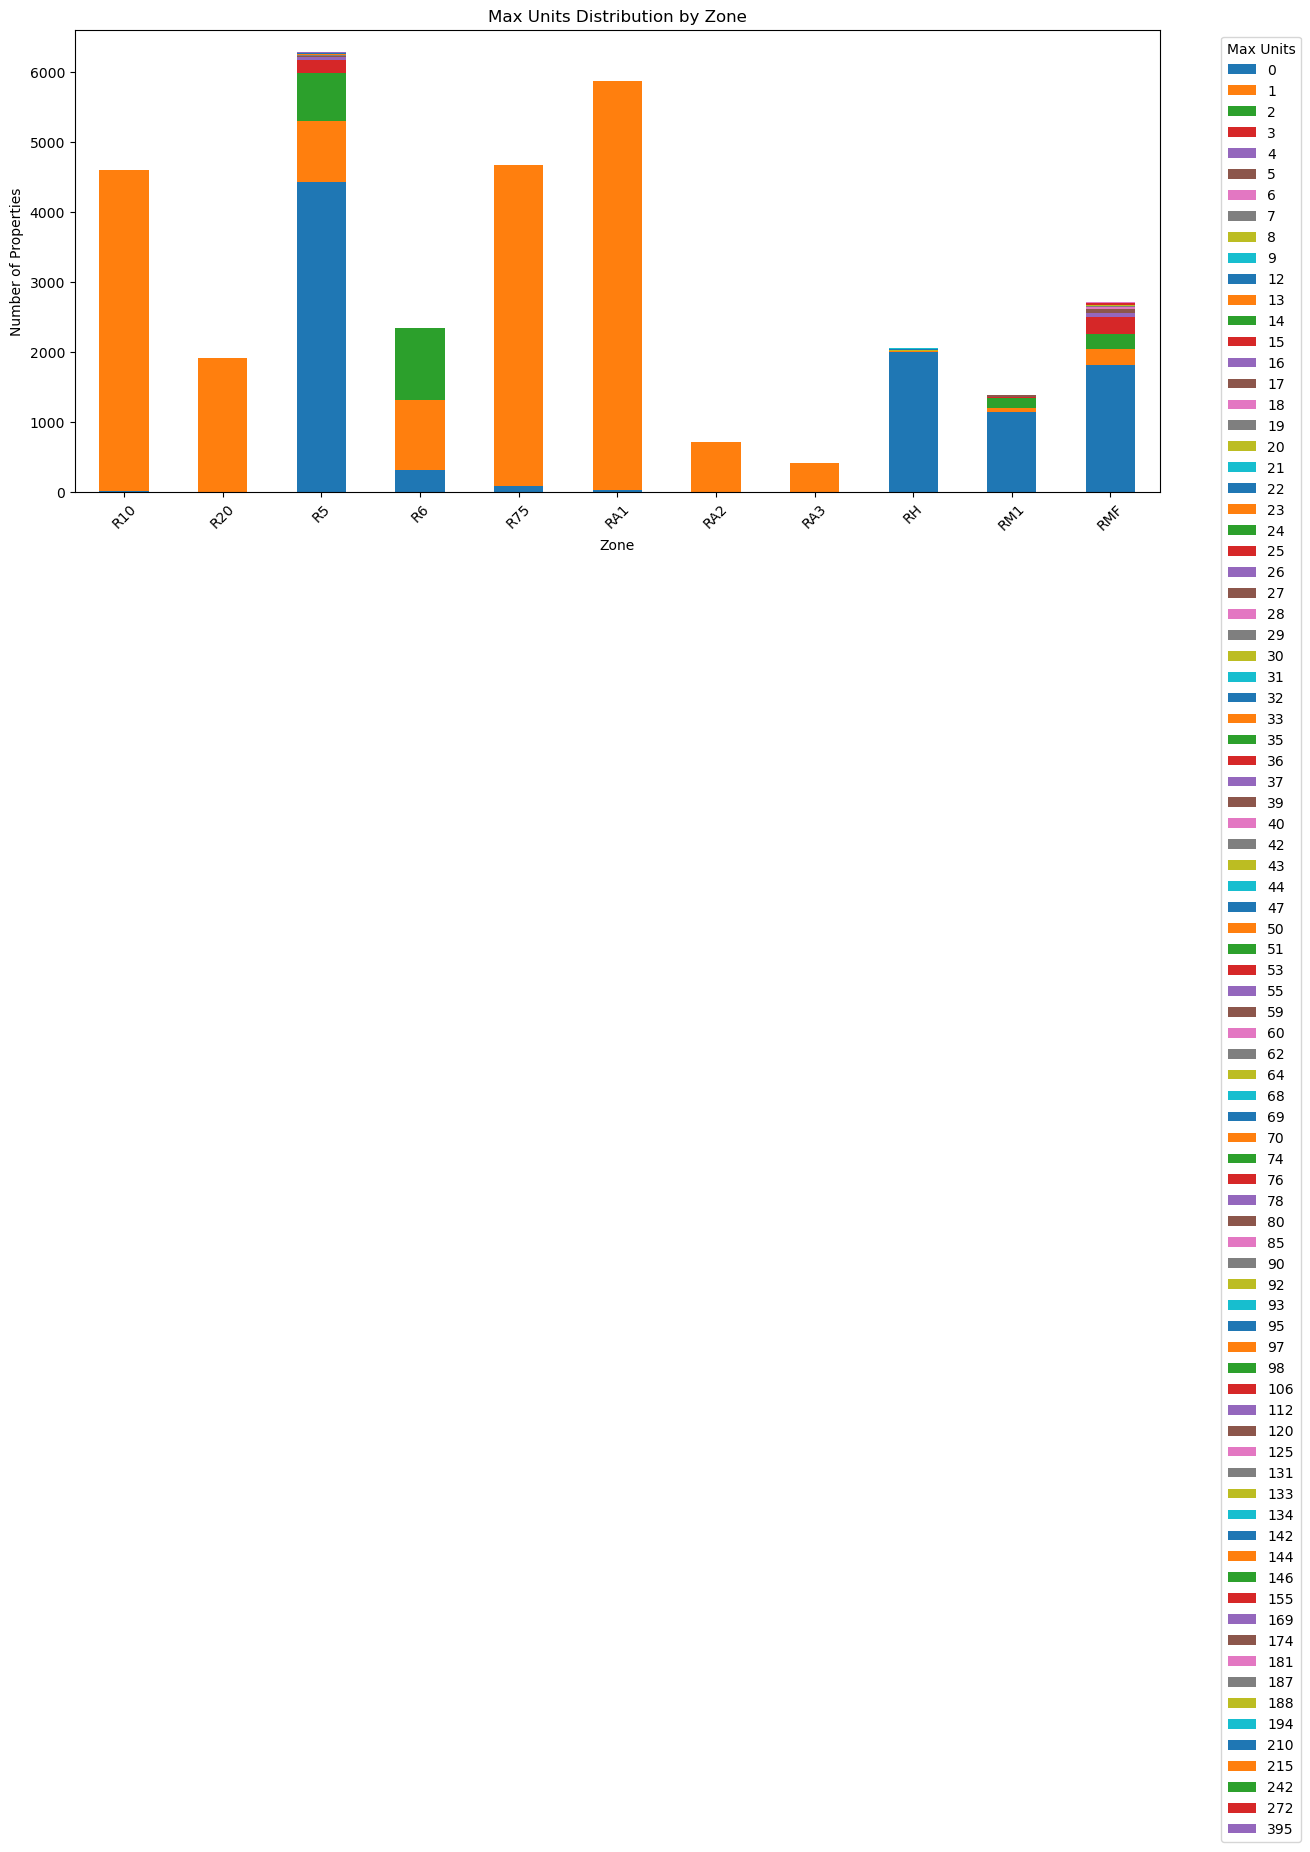

In [132]:
# Cell 7: Create visualizations
# Distribution of max units
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
df_residential['Max Units'].hist(bins=50, edgecolor='black')
plt.title('Distribution of Max Units')
plt.xlabel('Max Units')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
df_residential[df_residential['Max Units'] <= 10]['Max Units'].hist(bins=20, edgecolor='black')
plt.title('Distribution of Max Units (≤10)')
plt.xlabel('Max Units')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Max units by zone
plt.figure(figsize=(14, 6))
zone_counts = df_residential.groupby(['Zone', 'Max Units']).size().unstack(fill_value=0)
zone_counts.plot(kind='bar', stacked=True, figsize=(14, 6))
plt.title('Max Units Distribution by Zone')
plt.xlabel('Zone')
plt.ylabel('Number of Properties')
plt.legend(title='Max Units', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [133]:
# Cell 8: Identify interesting cases
# Properties with high unit potential
high_density = df_residential[df_residential['Max Units'] >= 10].copy()
print(f"Properties with 10+ max units: {len(high_density)}")
if len(high_density) > 0:
    print("\nTop 10 highest density properties:")
    print(high_density.nlargest(10, 'Max Units')[['Property Address', 'Zone', 'Land sq. ft.', 'Max Units']])

# Properties that can't be developed (0 max units)
undevelopable = df_residential[df_residential['Max Units'] == 0].copy()
print(f"\nUndevelopable properties (0 max units): {len(undevelopable)}")
if len(undevelopable) > 0:
    print("Reasons for 0 max units by zone:")
    print(undevelopable.groupby('Zone').size())

Properties with 10+ max units: 136

Top 10 highest density properties:
                 Property Address Zone  Land sq. ft.  Max Units
33946         1101 BEDFORD STREET   RH        286642        395
11633          130 MORGAN STREET    RH        197497        272
19861   1194 WASHINGTON BOULEVARD   RH        175852        242
34473          60 GLENBROOK ROAD    RH        156241        215
15851       0 CONNECTICUT AVENUE   RM1        791050        210
1536   1455 WASHINGTON BOULEVARD    RH        141309        194
31201            112 HOYT STREET    RH        136956        188
15040          111 MORGAN STREET    RH        135759        187
23183      412 STILLWATER AVENUE   RM1        679100        181
29401              566 ELM STREET  RMF        261055        174

Undevelopable properties (0 max units): 9786
Reasons for 0 max units by zone:
Zone
R10       3
R5     4422
R6      312
R75      74
RA1      18
RA2       1
RH     2003
RM1    1141
RMF    1812
dtype: int64


In [134]:
# Cell 9: Compare with existing units (if available)
# Check if there's useful data in the 'Number of Units' column
print("Existing 'Number of Units' column analysis:")
print(f"Unique values: {sorted(df_residential['Number of Units'].unique())}")
print(f"Value counts:\n{df_residential['Number of Units'].value_counts()}")

# Try to convert to numeric if possible
df_residential['Current Units'] = pd.to_numeric(df_residential['Number of Units'], errors='coerce')

# Compare current vs max units where both are available
comparison = df_residential[df_residential['Current Units'].notna() & (df_residential['Max Units'] > 0)].copy()
if len(comparison) > 0:
    comparison['Underutilized'] = comparison['Max Units'] > comparison['Current Units']
    print(f"\nProperties that could add more units: {comparison['Underutilized'].sum()}")



Existing 'Number of Units' column analysis:
Unique values: [nan]
Value counts:
Series([], Name: count, dtype: int64)


In [135]:
# Cell 10: Export results
# Save the enhanced dataset
output_filename = 'Stamford_Properties_with_MaxUnits.csv'
df_residential.to_csv(output_filename, index=False)
print(f"Enhanced dataset saved as: {output_filename}")

# Create a summary report
summary_stats = {
    'Total Properties': len(df_residential),
    'Developable Properties': (df_residential['Max Units'] > 0).sum(),
    'Undevelopable Properties': (df_residential['Max Units'] == 0).sum(),
    'Average Max Units': df_residential['Max Units'].mean(),
    'Total Potential Units': df_residential['Max Units'].sum(),
    'Properties with 2+ Units Potential': (df_residential['Max Units'] >= 2).sum(),
    'Properties with 5+ Units Potential': (df_residential['Max Units'] >= 5).sum(),
}

print("\n" + "="*50)
print("SUMMARY REPORT")
print("="*50)
for key, value in summary_stats.items():
    if isinstance(value, float):
        print(f"{key}: {value:.2f}")
    else:
        print(f"{key}: {value:,}")

Enhanced dataset saved as: Stamford_Properties_with_MaxUnits.csv

SUMMARY REPORT
Total Properties: 32,960
Developable Properties: 23,174
Undevelopable Properties: 9,786
Average Max Units: 1.08
Total Potential Units: 35,515
Properties with 2+ Units Potential: 2,937
Properties with 5+ Units Potential: 301
